# Preliminary Strain Calculations in the LIT-PCBA Dataset

* Protein: Opioid Kappa Receptor 1
* PDB: 67B3
* Protein Preparation: Default
* Grid: Default 
* Ligands: Full Dataset
* Ligand Preparation: Default 
* Docking: Glide (default) 

In [2]:
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc  # Importing the auc function

In [3]:
def load_sdf_to_dataframe(filename, active):
    """
    Load molecules and their properties from an SDF file into a DataFrame.
    
    This is very inefficient and should only be used for small datasets.
    I will rewrite this in the future to use a more efficient method.
    Likely by `parallel` in bash and saving the pickle file. 

    Parameters:
    filename (str): The path to the SDF file.
    active (bool): Flag indicating whether the molecules are active or not.

    Returns:
    pandas.DataFrame: The DataFrame containing the loaded molecules and their properties.
    """
    # Create a molecule supplier
    mol_supplier = Chem.SDMolSupplier(filename)

    # Load the molecules and their properties into a list
    molecules = []
    for mol in mol_supplier:
        if mol is not None:
            props = mol.GetPropsAsDict()
            props['Title'] = mol.GetProp('_Name')
            props['Mol'] = mol
            props['Activity'] = 1 if active else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ['Title', 'Mol', 'Activity'] + [col for col in df.columns if col not in ['Title', 'Mol', 'Activity']]
    df = df[cols]

    return df

# Usage:
#active = load_sdf_to_dataframe('67B3_actives.sdf', active=True)
#inactive = load_sdf_to_dataframe('67B3_inactives.sdf', active=False)

In [4]:
def save_to_pickle(df, filename):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)

# Usage:
#save_to_pickle(active, '67B3_actives.pkl')
#save_to_pickle(inactive, '67B3_inactives.pkl')

In [10]:
# function to load our pickle dataframes back into memory
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        df = pickle.load(f)
    return df

# Usage:
active = load_from_pickle('67B3_actives.pkl')
inactive = load_from_pickle('67B3_inactives.pkl')


Making rdkit mol objects from the SDF takes a long time. 

`./multi_sdsubset.sh` is a hardcoded script to split the `67B3_inactives.sdf` (~500K) into 10 parts (~50K) using Schrodinger tools. The command runs in parallel via & oeprators. 

`./multi_torsion_strain.sh` is a hardcoded script to take those `subset_*.sdf` that runs in parallel via the `parallel` functionality via `brew install parallel`. It runs my refactored torsion strain script to write the torsion csv files. 

Now we can load the csv files. We will start with the inactives:

In [11]:
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now. 

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [12]:
import glob

# Use glob to get csv files ('subset_*.csv) from the directory
csv_files = glob.glob("subset_*.csv")

# Sort the list of files by the number in their names
csv_files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Check the order
print(csv_files)

# Concatenate the CSV files
OPRK1_inactives_strain = concatenate_csv_files(csv_files)

# Molecule_Name is being read as a float, so convert it to a string
OPRK1_inactives_strain["Molecule_Name"] = OPRK1_inactives_strain["Molecule_Name"].astype(str)

# Display the first five rows
display(OPRK1_inactives_strain.head())

# Display summary statistics, rounded to one decimal places
display(OPRK1_inactives_strain.describe().round(1))

['subset_1.csv', 'subset_2.csv', 'subset_3.csv', 'subset_4.csv', 'subset_5.csv', 'subset_6.csv', 'subset_7.csv', 'subset_8.csv', 'subset_9.csv', 'subset_10.csv']


,Molecule_Name,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,17407344,10.874642,8.114060,NaN,1.0
1,24784061,11.043108,10.040673,NaN,7.0
2,17407000,11.432821,7.485982,NaN,1.0
3,47201060,5.091219,4.529746,5.913435,4.0
4,22409465,6.849733,5.756975,NaN,5.0


,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
count,528089.0,528089.0,269569.0,528089.0
mean,5.8,4.7,inf,2.7
std,3.3,2.6,NaN,2.2
min,-2.0,-0.1,0.0,0.0
25%,3.4,2.8,2.8,1.0
50%,5.4,4.4,4.6,2.0
75%,7.8,6.3,7.7,4.0
max,30.9,23.3,inf,18.0


Now we will load the actives in a similar way. 

In [13]:
# We can still use concatenate_csv_files() to read in the active strain data
OPRK1_actives_strain = concatenate_csv_files(["67B3_actives.csv"])

# Molecule_Name is being read as a float, so convert it to a string
OPRK1_actives_strain["Molecule_Name"] = OPRK1_actives_strain["Molecule_Name"].astype(str)

# Display the first five rows
display(OPRK1_actives_strain.head())

# Display summary statistics, rounded to one decimal places
display(OPRK1_actives_strain.describe().round(1))


,Molecule_Name,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,14742361,7.743401,6.452040,NaN,4
1,14721919,9.862600,7.793637,NaN,1
2,14733740,9.336486,7.212523,NaN,8
3,51085197,7.962479,6.610545,inf,2
4,11532953,7.557015,5.150796,NaN,0


,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
count,38.0,38.0,14.0,38.0
mean,7.2,5.8,inf,3.1
std,2.8,2.3,NaN,2.4
min,0.9,0.7,1.2,0.0
25%,5.8,4.9,2.8,1.0
50%,8.2,6.8,3.2,2.5
75%,9.3,7.6,7.1,4.0
max,10.5,8.8,inf,8.0


Now let's clean up the docking data so we can merge this. 

In [14]:
# We have already loaded the docking data into dataframes: active and inactive

# Convert the 'Title' column to a string in both dataframes
active["Title"] = active["Title"].astype(str)
inactive["Title"] = inactive["Title"].astype(str)

# Rename the 'Title' column to 'Molecule_Name' in both dataframes
active.rename(columns={"Title": "Molecule_Name"}, inplace=True)
inactive.rename(columns={"Title": "Molecule_Name"}, inplace=True)
# Merge the strain data for the active and inactive datasets as a deep copy 
# so that the original dataframes are not modified
active_data = active.merge(OPRK1_actives_strain, how="left", on="Molecule_Name").copy(deep=True)
inactive_data = inactive.merge(OPRK1_inactives_strain, how="left", on="Molecule_Name").copy(deep=True)

# Display the first five rows of the active_data dataframe
display(active_data.head())
# Display the first five rows of the inactive_data dataframe
display(inactive_data.head())

# Concatenate the active and inactive dataframes as "all_data"
all_data = pd.concat([active_data, inactive_data], ignore_index=True)

# Display the first five rows of the all_data dataframe
display(all_data.head())

,Molecule_Name,Mol,Activity,i_epik_Tot_Q,i_epik_Tot_abs_Q,i_i_glide_confnum,i_i_glide_lignum,i_i_glide_posenum,i_i_glide_rotatable_bonds,i_lp_mmshare_version,...,s_epik_input,s_i_glide_gridfile,s_lp_Force_Field,s_lp_Variant,s_m_source_file,s_epik_Chemistry_Notes,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5
1,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5
2,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5
3,14742361,<rdkit.Chem.rdchem.Mol object at 0x2a4b058f0>,1,0,0,27,19,280,7,53161,...,bjFbY0hdW2NIXVtjSF1bY0hdYzFDKD1PKU4oW0NIMl1bQ0...,glide-grid_67B3_PL_Complex,S-OPLS,14742361-1,actives.smi,NaN,7.743401,6.452040,NaN,4
4,14721919,<rdkit.Chem.rdchem.Mol object at 0x2a4b05940>,1,0,0,49,11,194,9,53161,...,W0NIM11PYzFbY0hdW2NIXWMoW2NIXWMxT1tDSDNdKVtDSD...,glide-grid_67B3_PL_Complex,S-OPLS,14721919-1,actives.smi,NaN,9.862600,7.793637,NaN,1


,Molecule_Name,Mol,Activity,i_epik_Tot_Q,i_epik_Tot_abs_Q,i_i_glide_confnum,i_i_glide_lignum,i_i_glide_posenum,i_i_glide_rotatable_bonds,i_lp_mmshare_version,...,s_epik_cmdline,s_epik_input,s_i_glide_gridfile,s_lp_Force_Field,s_lp_Variant,s_m_source_file,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,17509036,<rdkit.Chem.rdchem.Mol object at 0x2a4b100e0>,0,0,0,44,321604,9,13,53161,...,J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLXRuJy...,W2NIXTFbY0hdW2NIXVtjSF1jKGMxMilDKD1PKU4oQzI9Ty...,glide-grid_67B3_PL_Complex,S-OPLS,17509036-1,inactives.smi,12.383258,10.774766,inf,7.0
1,17407344,<rdkit.Chem.rdchem.Mol object at 0x2a4b10950>,0,0,0,150,346148,314,10,53161,...,J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLXRuJy...,bjFbY0hdW2NIXW5bY0hdYzFDKD1PKU4oW0NIMl0yKVtDQE...,glide-grid_67B3_PL_Complex,S-OPLS,17407344-1,inactives.smi,10.874642,8.114060,NaN,1.0
2,17407344,<rdkit.Chem.rdchem.Mol object at 0x2a4b10950>,0,0,0,150,346148,314,10,53161,...,J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLXRuJy...,bjFbY0hdW2NIXW5bY0hdYzFDKD1PKU4oW0NIMl0yKVtDQE...,glide-grid_67B3_PL_Complex,S-OPLS,17407344-1,inactives.smi,13.079049,10.251546,NaN,1.0
3,24784061,<rdkit.Chem.rdchem.Mol object at 0x2a4b109a0>,0,0,0,375,271415,293,15,53161,...,J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLXRuJy...,W0NIM11PYzFbY0hdW2NIXWMoW2NIXVtjSF0xKUMoPU8pW0...,glide-grid_67B3_PL_Complex,S-OPLS,24784061-1,inactives.smi,11.043108,10.040673,NaN,7.0
4,24784061,<rdkit.Chem.rdchem.Mol object at 0x2a4b109a0>,0,0,0,375,271415,293,15,53161,...,J2VwaWtfcHl0aG9uJywgJy1waCcsICc3LjAnLCAnLXRuJy...,W0NIM11PYzFbY0hdW2NIXWMoW2NIXVtjSF0xKUMoPU8pW0...,glide-grid_67B3_PL_Complex,S-OPLS,24784061-1,inactives.smi,11.043108,10.040673,NaN,7.0


,Molecule_Name,Mol,Activity,i_epik_Tot_Q,i_epik_Tot_abs_Q,i_i_glide_confnum,i_i_glide_lignum,i_i_glide_posenum,i_i_glide_rotatable_bonds,i_lp_mmshare_version,...,s_epik_input,s_i_glide_gridfile,s_lp_Force_Field,s_lp_Variant,s_m_source_file,s_epik_Chemistry_Notes,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5.0
1,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5.0
2,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,1,1,152,33,258,9,53161,...,W2NIXTFbY0hdYyhGKVtjSF1bY0hdYzFbTkhdQyg9TylbQ0...,glide-grid_67B3_PL_Complex,S-OPLS,49819640-1,actives.smi,NaN,5.802496,4.853557,7.136432,5.0
3,14742361,<rdkit.Chem.rdchem.Mol object at 0x2a4b058f0>,1,0,0,27,19,280,7,53161,...,bjFbY0hdW2NIXVtjSF1bY0hdYzFDKD1PKU4oW0NIMl1bQ0...,glide-grid_67B3_PL_Complex,S-OPLS,14742361-1,actives.smi,NaN,7.743401,6.452040,NaN,4.0
4,14721919,<rdkit.Chem.rdchem.Mol object at 0x2a4b05940>,1,0,0,49,11,194,9,53161,...,W0NIM11PYzFbY0hdW2NIXWMoW2NIXWMxT1tDSDNdKVtDSD...,glide-grid_67B3_PL_Complex,S-OPLS,14721919-1,actives.smi,NaN,9.862600,7.793637,NaN,1.0


In [15]:
# Make a subset of all_data containing these columns: 'Molecule_Name', 'Mol', 'Activity', 'r_i_docking_score', 'Total_E', 'Lower_Bound', 'Upper_Bound'
all_data_subset = all_data[['Molecule_Name', 'Mol', 'Activity', 'r_i_docking_score', 'Total_E', 'Lower_Bound', 'Upper_Bound']].copy(deep=True)
all_data_subset



,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound
0,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,-8.36082,5.802496,4.853557,7.136432
1,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,-8.36082,5.802496,4.853557,7.136432
2,49819640,<rdkit.Chem.rdchem.Mol object at 0x2a4b058a0>,1,-8.36082,5.802496,4.853557,7.136432
3,14742361,<rdkit.Chem.rdchem.Mol object at 0x2a4b058f0>,1,-8.31699,7.743401,6.452040,NaN
4,14721919,<rdkit.Chem.rdchem.Mol object at 0x2a4b05940>,1,-7.92756,9.862600,7.793637,NaN
...,...,...,...,...,...,...,...
2296862,17412195,<rdkit.Chem.rdchem.Mol object at 0x437d10630>,0,2.44014,10.717299,8.919937,NaN
2296863,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN
2296864,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN
2296865,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN


First pass at enrichment metrics, not familiar with this.

In [16]:
# Sort the subset by 'r_i_docking_score' in ascending order
all_data_subset.sort_values(by="r_i_docking_score", inplace=True)

# Reset the index so that we are ranking by the docking score
all_data_subset.reset_index(drop=True, inplace=True)

# Add 1 to the index so we can take a log later
all_data_subset.index += 1  # Adjusting the index to start from 1

# Calculate the cumulative sum of active compounds
# (i.e. the number of active compounds at each row)
all_data_subset["Cumulative_Actives"] = all_data_subset["Activity"].cumsum()

# Calaulate the Total Actives (i.e. the total number of active compounds)
# This is a constant value, unlike cumsum
all_data_subset["Total_Actives"] = all_data_subset["Activity"].sum()

# Calculate the fraction of identified actives at each row
# This column progresses from 0 to 1 as actives are identified
all_data_subset["Fraction_Actives"] = (
    all_data_subset["Cumulative_Actives"] / all_data_subset["Total_Actives"]
)

# Calculate the logarithm of the ranking at each row, via the index
# This for the 'log' part of LogAUC 
all_data_subset["Log_Fraction_Actives"] = np.log1p(all_data_subset.index)

# Calculate the logAUC
log_auc = auc(all_data_subset["Log_Fraction_Actives"], all_data_subset["Fraction_Actives"])

all_data_subset

,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,17509036,<rdkit.Chem.rdchem.Mol object at 0x2a4b100e0>,0,-11.37900,12.383258,10.774766,inf,0,79,0.0,0.693147
2,17407344,<rdkit.Chem.rdchem.Mol object at 0x2a4b10950>,0,-11.05610,13.079049,10.251546,NaN,0,79,0.0,1.098612
3,17407344,<rdkit.Chem.rdchem.Mol object at 0x2a4b10950>,0,-11.05610,10.874642,8.114060,NaN,0,79,0.0,1.386294
4,24784061,<rdkit.Chem.rdchem.Mol object at 0x2a4b109a0>,0,-10.92740,11.043108,10.040673,NaN,0,79,0.0,1.609438
5,24784061,<rdkit.Chem.rdchem.Mol object at 0x2a4b109a0>,0,-10.92740,11.043108,10.040673,NaN,0,79,0.0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...
2296863,17412195,<rdkit.Chem.rdchem.Mol object at 0x437d10630>,0,2.44014,10.717299,8.919937,NaN,79,79,1.0,14.647055
2296864,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647056
2296865,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647056
2296866,26662803,<rdkit.Chem.rdchem.Mol object at 0x437d10680>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647057


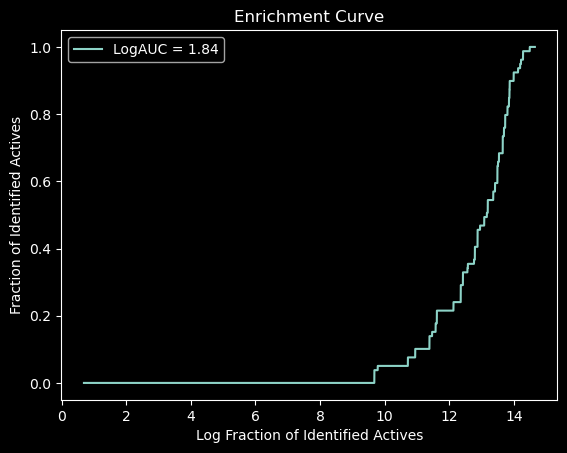

In [17]:
# Plot the logAUC
plt.plot(
    all_data_subset["Log_Fraction_Actives"],
    all_data_subset["Fraction_Actives"],
    label="LogAUC = {:.2f}".format(log_auc),
)

# Add axis labels and title
plt.xlabel("Log Fraction of Identified Actives")
plt.ylabel("Fraction of Identified Actives")
plt.title("Enrichment Curve")

plt.legend()
plt.show()


Now I need to figure out how the authors calculated their &Delta;LogAUC

I am not exactly sure how that works, but what we can do more easily is evaluate LogAUC as a function of Strain Energy Cut Offs to see if the incorportation of strain has a measurable effect on LogAUC enrichment. 

What we want is a function that will 

1. Filter `all_data_subset` dataframe by various values of `Total_E`. The highest reported strain for an active molecule in this set is 10.5, the lowest is 0.9. We can divide this into ten ranges from 0.9 to 10.5. 
2. Convert those filtered subsets to the appropriate form for calculation of logAUC  



In [28]:
all_data_subset = all_data[['Molecule_Name', 'Mol', 'Activity', 'r_i_docking_score', 'Total_E', 'Lower_Bound', 'Upper_Bound']].copy(deep=True) 

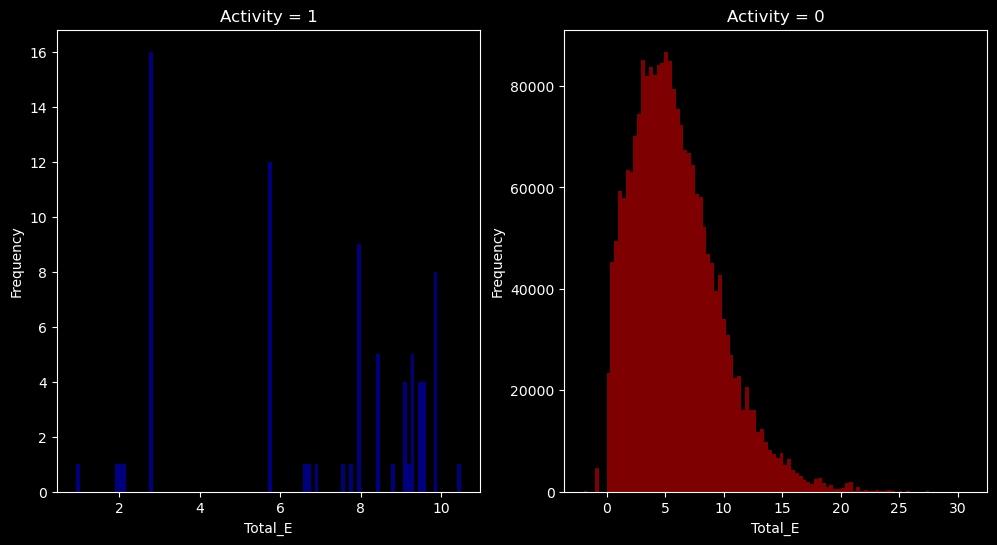

In [23]:
# Filter the dataframe for Activity == 1 and Activity == 0
active_data = all_data_subset[all_data_subset['Activity'] == 1]['Total_E']
inactive_data = all_data_subset[all_data_subset['Activity'] == 0]['Total_E']

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create the histogram for Activity == 1
axs[0].hist(active_data, bins=100, alpha=0.5, color='blue')
axs[0].set_title('Activity = 1')
axs[0].set_xlabel('Total_E')
axs[0].set_ylabel('Frequency')

# Create the histogram for Activity == 0
axs[1].hist(inactive_data, bins=100, alpha=0.5, color='red')
axs[1].set_title('Activity = 0')
axs[1].set_xlabel('Total_E')
axs[1].set_ylabel('Frequency')

plt.show()

In [27]:
import pandas as pd

# Filter the dataframe for Activity == 1 and Activity == 0
active_data = all_data_subset[all_data_subset['Activity'] == 1]['Total_E']
inactive_data = all_data_subset[all_data_subset['Activity'] == 0]['Total_E']

# Get the summary statistics for both cases
active_summary = active_data.describe().round(1)
inactive_summary = inactive_data.describe().round(1)

# Convert the summary statistics to dataframes
active_summary_df = pd.DataFrame(active_summary)
inactive_summary_df = pd.DataFrame(inactive_summary)

# Rename the columns
active_summary_df.columns = ['Activity = 1']
inactive_summary_df.columns = ['Activity = 0']

# Concatenate the dataframes side by side
summary_df = pd.concat([active_summary_df, inactive_summary_df], axis=1)

# Display the dataframe
display(summary_df)

,Activity = 1,Activity = 0
count,79.0,2268562.0
mean,6.8,5.9
std,2.8,3.7
min,0.9,-2.0
25%,4.3,3.1
50%,8.0,5.4
75%,9.3,8.1
max,10.5,30.9


In [63]:
def divide_dataframe(df):
    """
    Divides a dataframe into ten subsets based on the range of 'Total_E' values for rows where 'Activity' is 1. The divided dataframes correspond to ten even steps from the strain energy (`Total_E`) values found for the active compounds. The first dataframe will consider all the data where `Total_E` is less than or equal to the minimum `Total_E` value for the active compounds. The second dataframe will consider all the data where `Total_E` is less than or equal to the second lowest `Total_E` value for the active compounds, and so on.

    Parameters:
    df (pandas.DataFrame): The input dataframe.

    Returns:
    list, list: A list of ten dataframes, each representing a subset of the input dataframe, and a list of the upper bounds used for each subset.

    Usage:

    divided_dataframes, upper_bounds = divide_dataframe(dataframe)

    """
    # Calculate the range of 'Total_E' for rows where 'Activity' is 1
    min_total_e = df[df["Activity"] == 1]["Total_E"].min()
    max_total_e = df[df["Activity"] == 1]["Total_E"].max()

    # Calculate the step size for the division
    step = (max_total_e - min_total_e) / 10

    # Create a list to store the divided dataframes and the upper bounds
    divided_dfs = []
    upper_bounds = []

    # Divide the dataframe into ten subsets
    for i in range(10):
        upper_bound = min_total_e + (i + 1) * step
        subset = df[(df["Total_E"] <= upper_bound)]
        divided_dfs.append(subset)
        upper_bounds.append(upper_bound)

    return divided_dfs, upper_bounds


divided_dataframes, upper_bounds = divide_dataframe(all_data_subset)

print(f"Upper bounds: {upper_bounds}")
print()
print(f"Shape of input datafrane: {all_data_subset.shape}")
for i, df in enumerate(divided_dataframes):
    print(f"Shape of dataframe {i}: {df.shape}")
    print(
        f"Total_E range for Activity == 1: {df[df['Activity'] == 1]['Total_E'].min()} to {df[df['Activity'] == 1]['Total_E'].max()}"
    )
    print(f"Total amount of actives: {df[df['Activity'] == 1]['Total_E'].count()}")
    print(f"Total_E range: {df['Total_E'].min()} to {df['Total_E'].max()}")
    print()

Upper bounds: [1.8869008254809603, 2.8420873358491936, 3.797273846217427, 4.75246035658566, 5.707646866953893, 6.662833377322126, 7.61801988769036, 8.573206398058593, 9.528392908426826, 10.48357941879506]

Shape of input datafrane: (2296867, 7)
Shape of dataframe 0: (293542, 7)
Total_E range for Activity == 1: 0.9317143151127268 to 0.9317143151127268
Total amount of actives: 1
Total_E range: -2.0 to 1.8868417036578964

Shape of dataframe 1: (491885, 7)
Total_E range for Activity == 1: 0.9317143151127268 to 2.798903384467618
Total amount of actives: 20
Total_E range: -2.0 to 2.842083217646693

Shape of dataframe 2: (731568, 7)
Total_E range for Activity == 1: 0.9317143151127268 to 2.798903384467618
Total amount of actives: 20
Total_E range: -2.0 to 3.797257558665307

Shape of dataframe 3: (975381, 7)
Total_E range for Activity == 1: 0.9317143151127268 to 2.798903384467618
Total amount of actives: 20
Total_E range: -2.0 to 4.752459368388409

Shape of dataframe 4: (1219901, 7)
Total_E ran

In [64]:
def process_dataframe(df):
    """
    Process the given dataframe for LogAUC and Enrichment Plots by performing the following steps:
    1. Sort the dataframe by 'r_i_docking_score' in ascending order.
    2. Reset the index to rank the dataframe by the docking score.
    3. Add 1 to the index to adjust it to start from 1.
    4. Calculate the cumulative sum of active compounds.
    5. Calculate the total number of active compounds.
    6. Calculate the fraction of identified actives at each row.
    7. Calculate the logarithm of the ranking at each row.

    Parameters:
    - df: pandas DataFrame, the input dataframe to be processed.

    Returns:
    - df: pandas DataFrame, the processed dataframe.

    Usage:

    processed_dataframes = [process_dataframe(df) for df in divided_dataframes]
    """
    df.sort_values(by="r_i_docking_score", inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    df["Cumulative_Actives"] = df["Activity"].cumsum()
    df["Total_Actives"] = df["Activity"].sum()
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]
    df["Log_Fraction_Actives"] = np.log1p(df.index)

    return df


processed_dataframes = [process_dataframe(df) for df in divided_dataframes]

for i, df in enumerate(processed_dataframes):
    display(df.head(n=3))

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_63357/3595234035.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="r_i_docking_score", inplace=True)
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_63357/3595234035.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cumulative_Actives"] = df["Activity"].cumsum()
/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_63357/3595234035.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.706568,1.448100,2.193057,0,1,0.0,0.693147
2,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.295750,1.153434,1.483289,0,1,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.745366,1.476577,2.245148,0,1,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.706568,1.448100,2.193057,0,20,0.0,0.693147
2,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.745366,1.476577,2.245148,0,20,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.875272,1.556430,2.599343,0,20,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.875272,1.556430,2.599343,0,20,0.0,0.693147
2,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.295750,1.153434,1.483289,0,20,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.706568,1.448100,2.193057,0,20,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.745366,1.476577,2.245148,0,20,0.0,0.693147
2,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.875272,1.556430,2.599343,0,20,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.295750,1.153434,1.483289,0,20,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,20,0.0,0.693147
2,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.875272,1.556430,2.599343,0,20,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.745366,1.476577,2.245148,0,20,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,33,0.0,0.693147
2,22407870,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c70>,0,-10.4288,5.973941,4.753797,NaN,0,33,0.0,1.098612
3,24808506,<rdkit.Chem.rdchem.Mol object at 0x2a4b10db0>,0,-10.3486,1.706568,1.448100,2.193057,0,33,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,36,0.0,0.693147
2,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,36,0.0,1.098612
3,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,36,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,51,0.0,0.693147
2,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,51,0.0,1.098612
3,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,51,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,66,0.0,0.693147
2,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,66,0.0,1.098612
3,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,66,0.0,1.386294


,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,47201060,<rdkit.Chem.rdchem.Mol object at 0x2a4b10ae0>,0,-10.6551,5.091219,4.529746,5.913435,0,79,0.0,0.693147
2,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,6.849733,5.756975,NaN,0,79,0.0,1.098612
3,22409465,<rdkit.Chem.rdchem.Mol object at 0x2a4b10c20>,0,-10.6429,8.665590,7.400011,NaN,0,79,0.0,1.386294


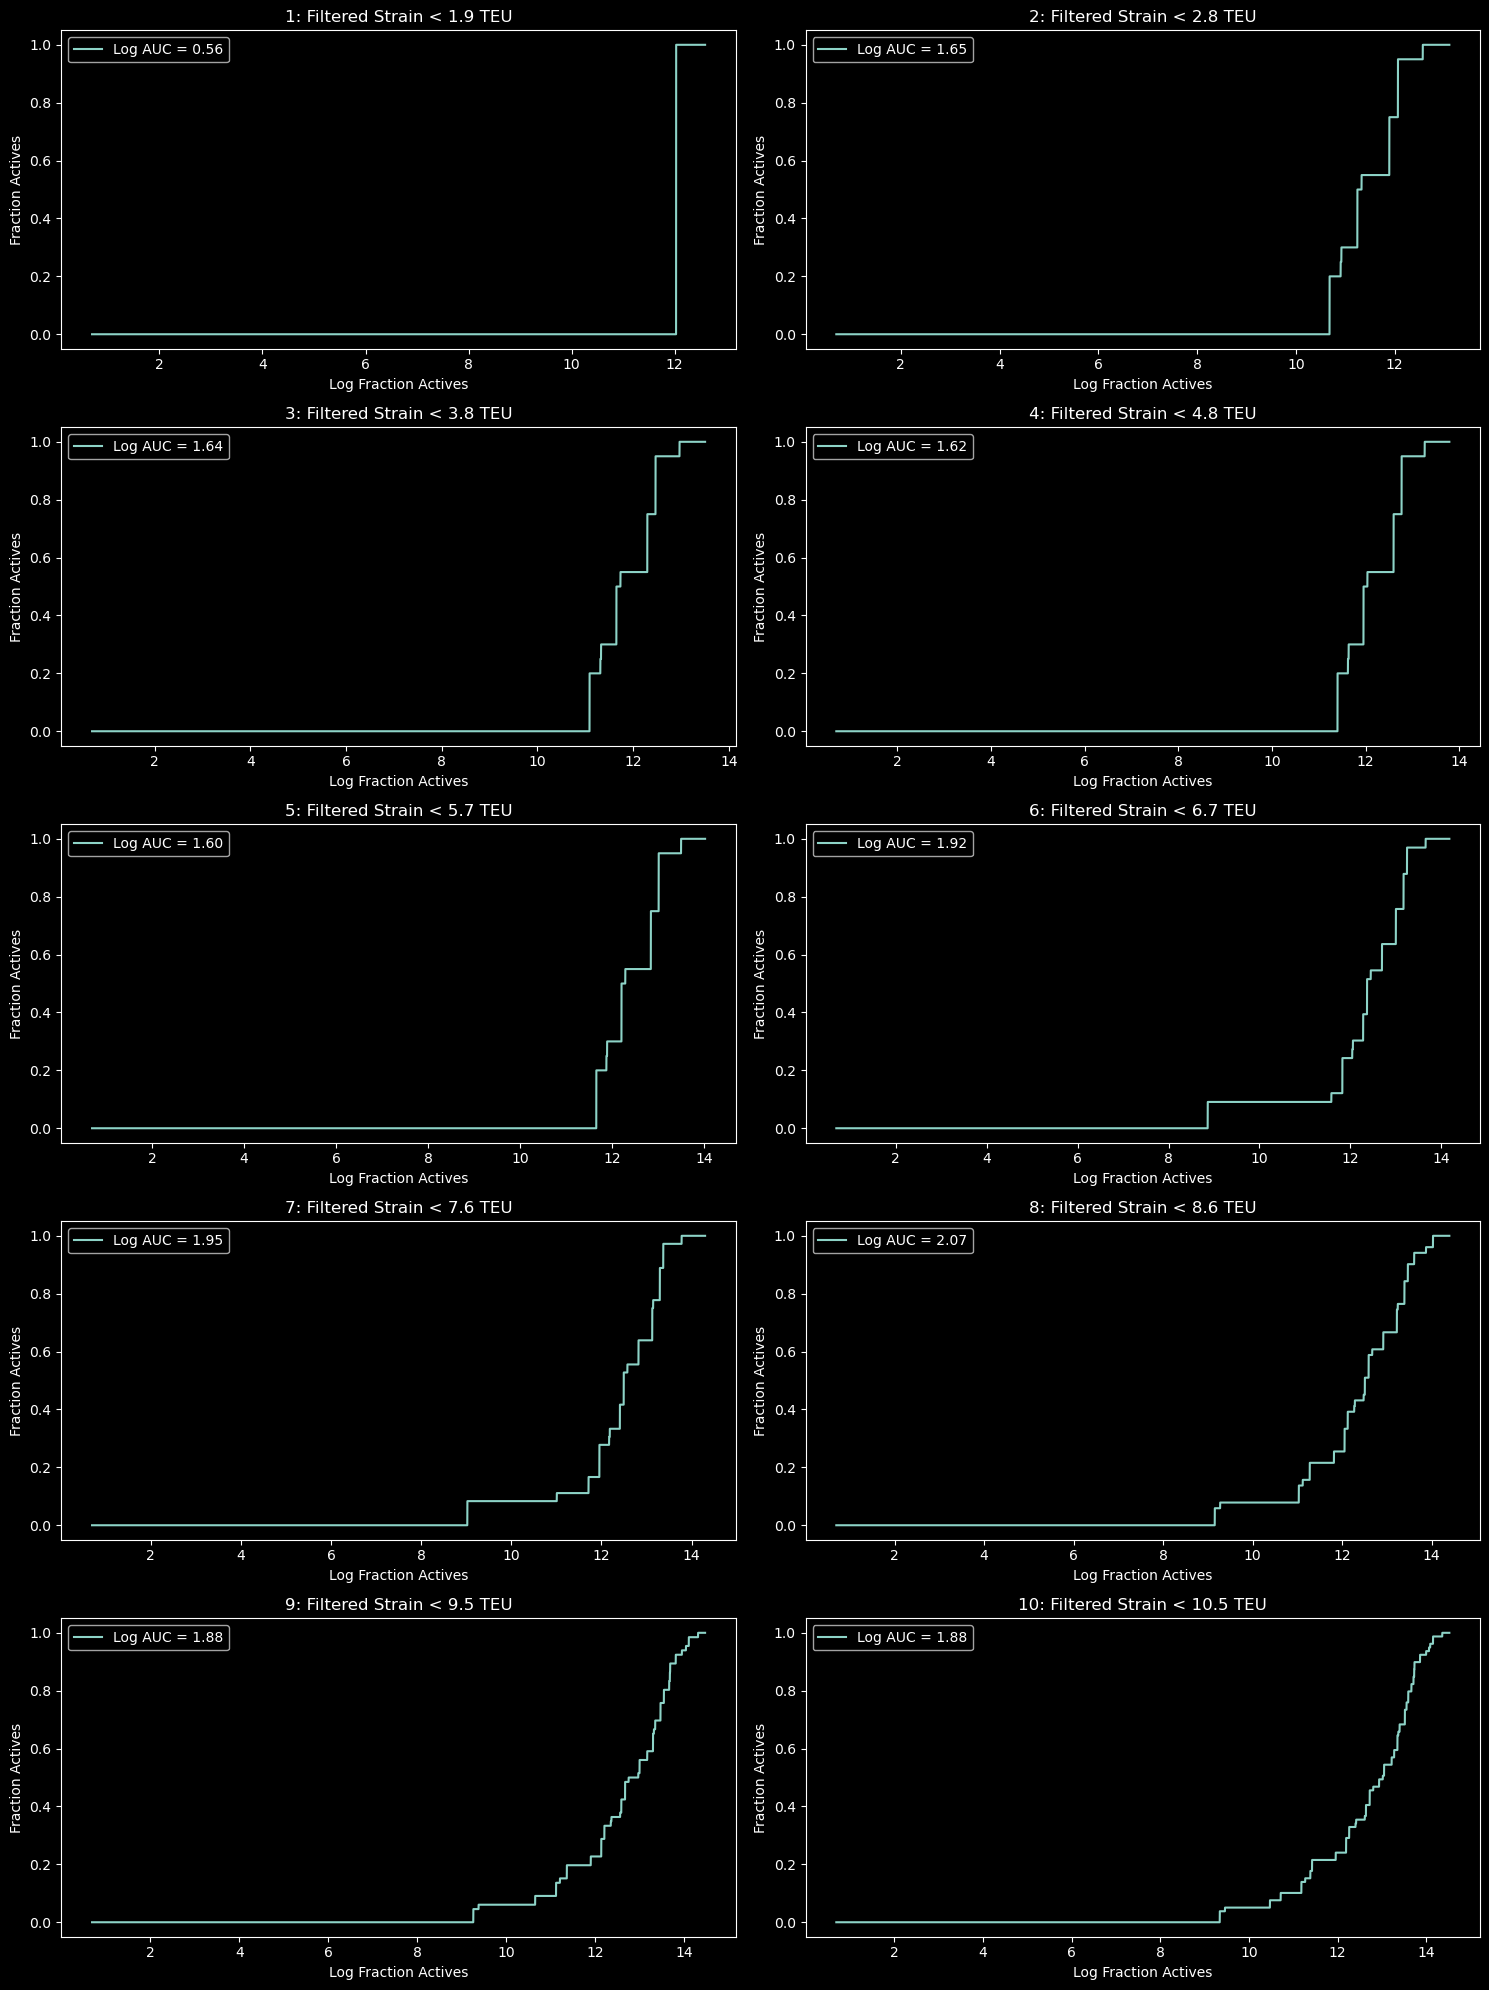

In [67]:
def plot_dataframes(dfs, upper_bounds):
    """
    Plots the Enrichment Curves with LogAUC from a list of dataframes.

    Parameters:
    dfs (list): A list of pandas DataFrames containing the data to be plotted.
    upper_bounds (list): A list of the upper bounds used for each subset.

    Returns:
    None

    Usage:

    plot_dataframes(processed_dataframes, upper_bounds)
    """
    fig, axs = plt.subplots(5, 2, figsize=(15, 20))

    for i, df in enumerate(dfs):

        # Calculate the log_auc
        log_auc = auc(df["Log_Fraction_Actives"], df["Fraction_Actives"])

        # Determine the subplot's position
        row = i // 2
        col = i % 2

        # Plot the data
        axs[row, col].plot(
            df["Log_Fraction_Actives"],
            df["Fraction_Actives"],
            label=f"Log AUC = {log_auc:.2f}",
        )
        axs[row, col].set_title(f"{i+1}: Filtered Strain < {round(upper_bounds[i], 1)} TEU")
        axs[row, col].set_xlabel("Log Fraction Actives")
        axs[row, col].set_ylabel("Fraction Actives")
        axs[row, col].legend()

    # Adjust the layout
    plt.tight_layout()
    plt.show()

plot_dataframes(processed_dataframes, upper_bounds)

Our original enrichment curve logAUC (without taking strain into account) was 1.84. So like the paper, we have improvement sometimes, but not always. We can make the LogAUC vs Strain Cut Off a little more obvious:

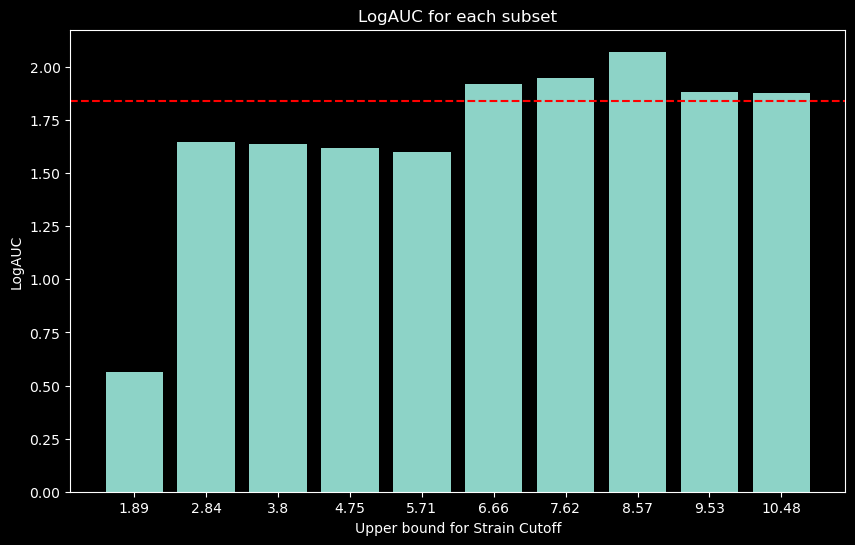

In [71]:
def plot_auc(dfs, upper_bounds):
    """
    Plots the AUC from a list of dataframes as a bar plot.

    Parameters:
    dfs (list): A list of pandas DataFrames containing the data to be plotted.
    upper_bounds (list): A list of the upper bounds used for each subset.

    Returns:
    None

    Usage:

    plot_auc(processed_dataframes, upper_bounds)
    """
    # Calculate the AUC for each dataframe
    auc_values = [auc(df["Log_Fraction_Actives"], df["Fraction_Actives"]) for df in dfs]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(auc_values)), auc_values, tick_label=[round(bound, 2) for bound in upper_bounds])

    # Set the title and labels
    plt.title("LogAUC for each subset")
    plt.xlabel("Upper bound for Strain Cutoff")
    plt.ylabel("LogAUC")

    # Draw a horizontal line for the pre-fitering logAUC
    plt.axhline(y=1.84, color='r', linestyle='--')

    # Show the plot
    plt.show()

plot_auc(processed_dataframes, upper_bounds)